In [0]:
#autoreload code before every run
%load_ext autoreload
%autoreload 2

In [0]:
from work.CS166.Traffic import CAExperiment, CASim, Lane, Highway

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output, HTML

import warnings
warnings.filterwarnings("ignore")

from functools import partial

# 1. Single Lane

## 1.1 Implementation

The code which implements  the Single and Multilane traffic simulations is available on Github repository [here](https://github.com/JoshBroomberg/traffic_simulation). It is also included in an appendix at the end of the paper.

- The implementation is based on a shared Cellular Automata Framework ([here](https://github.com/JoshBroomberg/traffic_simulation/tree/master/framework)) which implements an extensible pattern and utilities for running, visualizing and analyzing CA simulations. The framework has two classes: `CASim`, which is a single simulation, and `CAExperiment` which runs Monte Carlo simulations on a range of parameters for a given `CASim` instance.

- The single lane simulation is in a class called `Lane` with extends `CASim` and can thus be run on its own for a single lane traffic simulation. The multilane `Highway` class also inherits from `CASim`. It is composed of multiple `Lane` simulations with orchestrated interaction between their states for lane changes.

- All the heavy lifting is done in Numpy, including the calculation of whether cars should change lanes. Unfortunately, it proved to complex to implement the actual lane change execution in Numpy, so this is done using standard python loops. I found that it was more efficient to implement coditional updating of arrays through addition/multiplication rather than indexing (see [here](https://gist.github.com/JoshBroomberg/ab07c3de5adbc4519454184ed5e86be2) for analysis), so this pattern is used throughout.

- The `CAExperiment` class provides parallel execution via python multiprocessing. This further speeds up the execution of embaressing parallel repeat iterations.



#### Single Lane Run

A run of the simulation is parameterized by a dictionary of configuration variables and a dictionary of constants, which must be set for all `CASim` instances. The parameters are as follows:

- Traffic density: the expected density of the traffic. Each cell is initialized with a car with probability equal to this value.

- Max velocity: the max velocity of the cars.

- Probability of slow down: the probability with which a car slows down by one in a given step.

- Lane length: how long the lane is.

-  Maintain breaking distance: if true, cars attempt to stay in the middle of the car in front and behind. This is discussed later.

In [0]:
NUM_LANES = 1
ROAD_LENGTH = 200

states = {
    "EMPTY": (-1, Highway.COLOR_GREY),
    "V0": (0, Highway.COLOR_RED),
    "V1": (1, Highway.COLOR_ORANGE),
    "V2": (2, Highway.COLOR_YELLOW),
    "V3": (3, Highway.COLOR_GREEN),
    "V4": (4, Highway.COLOR_BLUE),
    "V5": (5, Highway.COLOR_PURPLE),
}

lane_sim_params_single={
  "traffic_density": 0.15,
  "max_velocity": 5,
  "p_slow_down": 0.5,
  "lane_length": ROAD_LENGTH,
  "maintain_braking_distance": False,
}

lane_constants = {
  "dim": (NUM_LANES, ROAD_LENGTH),
  "neighborhood_radii": (5, 0),
  "sim_states": states, # defined in the appendix, lists states with colors.
  "metrics": {}, # stats collected at each step
  "start_stats": {}, # stats collected at the start of the sim.
  "end_stats": {} # stats collected at the end of the sim.
}

lane = Lane(sim_params=lane_sim_params_single, **lane_constants)
lane.run_until_stable(max_steps=200, early_stop=False)

## 1.2 Visualization

Two visualizations of the simulation run are implemented. First, the pixel-based visualization in the Rickert, Nagel, Schrekenberg paper. This visualization strips velocity information but makes identifying queueing easy. Second, an animated visual which presents the cars as colored blocks moving on a road. The color spectrum is used to represent velocity, with red being stopped and purple being max velocity.

The first visualization is displayed below. The animation is available [here](https://drive.google.com/open?id=1rdX1C7REj1VBZEQUH3T1OPYyyeD3De55) (note it is not an animation of the same simulation run). I depart from the paper by initializing all cars to a random velocity rather than starting them from zero. This 'warms' up the simulation faster and reduces the probability that initial 'unrealistic' queueing from the cold start persists throughout.

As is clear from both visualizations, the simulation displays realistic spotaneous traffic formation and propagation. In the static visual below, there are long streaks of cars clustered tightly together. Thes clusters move backwards along the road as new cars join the back and old cars exit from the front.

The causal dynamic behind this queueing is clear from the animation. Observe that when a single car stops near the middle,  due to a random slow down, other cars behind it must stop/slow down and a queue forms and then propagates backward.

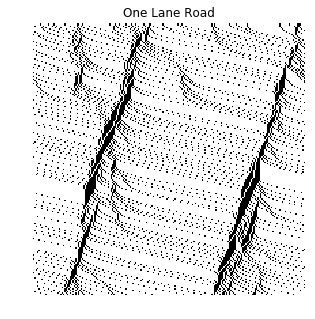

In [4]:
plt.figure(figsize=(5, 5))
ax = plt.axes()
lane.draw(title="One Lane Road", ax=ax)
# HTML(lane.video().to_html5_video())

## 1.3 The Response of Flow to Density

### Implementation

Below, the `CAExperiment` class is used to analyze how traffic flow responds to density. A road of length 200 is run for 30 densities evenly spaced between 0 and 1. Each density is repeated 50 times.

The first code block implements functions which calculate the density and flow metrics as defined in the original paper. Both are calculated by looking at cars in/passing through the final position in the lane. Note that the `CASim` calls these functions at the end of the run with the simulation instance. The functions can thus use the full history to find the average metric value across the complete sim time, as is done by the authors.

The second code block executes the experiment. Note that the sim param dictionary now contains lists rather than individual values. `CAExperiment` runs all combinations of the values in these lists.


### Results

The results of these two code blocks are displayed below. The first plot shows the raw data, and the second the 95% confidence interval for the mean. The mean and upper and lower bounds are found by binning the data. The interval  width is calculated empirically, using the 97.5th and 2.5th percentile of the data in each bin (no assumption of normality).

The charts match those in the original paper. Initially, flow increases rapidly with density as new cars are still able to move freely. There is then a critical phase transition at around a density of 0.1. Around this density, there is high variability in flow as congestion sometimes occurs and sometimes doesn't. This is evident from the wider interval in this region in Figure 2. After a short critical window, the flow steadily decreases with density as congestion is made more and more severe with added cars. These results almost exactly match those seen in the paper.


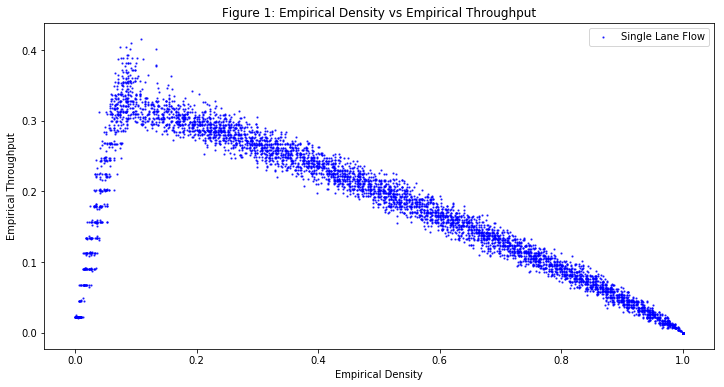

In [8]:
plt.figure(figsize=(12, 6))
ax = plt.axes()
lane_exp.results.plot(
    x="avg_density", y="avg_throughput_per_lane",
    kind="scatter", c="b", ax=ax, label="Single Lane Flow",
    s=1.5, alpha=0.7)

plt.title("Figure 1: Empirical Density vs Empirical Throughput")
plt.xlabel("Empirical Density")
plt.ylabel("Empirical Throughput")
plt.show()

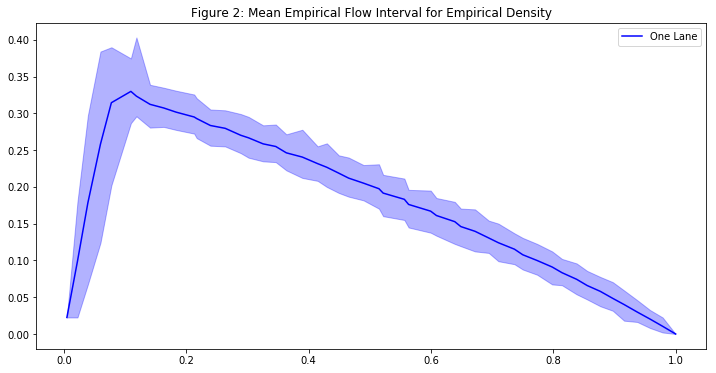

In [11]:
plot_flow_intervals(
    title="Figure 2: Mean Empirical Flow Interval for Empirical Density",
    results=[(lane_exp.results, "b", "One Lane")])

In [0]:
def average_lane_density(sim, history=None, prune=10):
  if history is None:
    history = np.array(sim.history)[prune:, :]
   
  # Determine if a car was present in the final block and
  # average counts over time.
  final_position_state = history[:, -1]
  return np.sum(final_position_state > -1)/len(history)

def average_lane_throughput(sim, history=None, prune=10):
  if history is None:
    history = np.array(sim.history)[prune:, :]
  
  # Find the position of the last car in the lane throughout time.
  reversed_lane_history = (history[:, ::-1] > -1)
  last_position_offset_from_end = np.argmax(reversed_lane_history, axis=1)
  last_car_position = (sim.lane_length - 1) - last_position_offset_from_end
  
  # Find the velocity of the last car.
  last_car_velocity = history[range(len(last_car_position)), last_car_position]
  
  # Determine if it had the velocity to cross the final block.
  escape_velocity_achieved = (last_car_position + last_car_velocity) >= sim.lane_length
  
  # Find if the first block is free. If it is, the car with escape velocity
  # would definitely cross. If not free, it couldn't cross.
  first_position_free = history[:, 0] == -1
  car_crosses_boundary = np.logical_and(
      first_position_free, escape_velocity_achieved)
  
  # Average the number of crossings over time.
  return np.sum(car_crosses_boundary)/len(history)

lane_end_stats = {
    "avg_density": average_lane_density,
    "avg_throughput_per_lane": average_lane_throughput
}

run_params={
  "max_steps": 5*10**2,
  "early_stop": False
}

In [7]:
ROAD_LENGTH = 200
NUM_LANES = 1

lane_sim_params_exp = {
  "traffic_density": np.linspace(0, 1, 50),
  "max_velocity": [5],
  "p_slow_down": [0.5],
  "maintain_braking_distance": [False],
  "lane_length": [ROAD_LENGTH],
}

lane_constant_params_exp = {
  "dim": (NUM_LANES, ROAD_LENGTH),
  "neighborhood_radii": (5, 0),
  "sim_states": states,
  "metrics": {},
  "start_stats": {},
  "end_stats": lane_end_stats
}

lane_exp = CAExperiment(
  num_repeats=100,
  sim_class=Lane,
  run_params=run_params,
  sim_params=lane_sim_params_exp,
  constant_sim_params=lane_constant_params_exp,
  stat_names = list(lane_constant_params_exp["end_stats"].keys()))

%time lane_exp.run(n_jobs=6)

Iteration time 0.039
Predicted single core total time 195.0
CPU times: user 90 ms, sys: 90 ms, total: 180 ms
Wall time: 42.7 s


# 2. Multilane Highway

## 2.1 Model Overview

The multilane simulation presents a highly simplified version reality. Each driver evaluates their current lane to determine if they can achieve a *desired* velocity (their current velocity plus one). This follows from the simple go-as-fast-as-possible behaviour from the single lane simulation.

If the driver cannot achieve their desired velocity in their current lane, they evaluate whether the other lanes available to them are desirable and viable. Desirable means that the desired velocity could be achieved in that lane (making it superior to the current lane) and viable means that changing would not block the car behind. If these three conditions are met (undesirable current lane, desirable and viable other lane) then the driver changes lanes, with some constant uncertainty/probability. In my implementation, this stochasticity is removed by setting the the probability of a lane change to 1. This results in some unrealistic behavior, like vehicles repeatedly changing between lanes, but experimentation revealed that this was not relevant for the flow.

In the taxonomy of the authors, this implementation assumes symmetry, a lack of stochasticity, and bidirectional causality (drivers look both ahead and behind and are thus influenced from both directions).

To formalize the parameters and assumptions:
- Drivers desire a change if the gap $g$ to the car in front of them is less than some constant $l$ where $l=v + 1$ and $v$ is current velocity.
- The other lane is desirable if the gap $g_o$ to the car that would be in front of the driver is greater than the same parameter $l$. Note that this assumes that cars move laterally into the other lane, without moving forward during the move. This assumption is fairly realistic if one considers that all cars are moving, making diagonal movement 'lateral' within the moving frame of reference.
- The other lane is viable is the gap $g_{o, back}$ to the car that would be behind the driver is larger than 5 length units. This is a rather naive behaviour which makes the drivers very cautious. Normally, the distance would depend on the speed of both drivers (the risk of collision).
- The driver checks all adjacent lanes, choosing to change into the first one that meets all the criteria above. This means each driver checks a maximum of two lanes per step, but only if there are more than two lanes. This is discussed in more detail in the next section.

## 2.2 Implementation

The multilane simulation is implemented in the `Highway` class [here](https://github.com/JoshBroomberg/traffic_simulation/blob/master/traffic_sim/highway.py).

## 2.3 Visualization

The flow of traffic in two lanes is visualized in an animation [here](https://drive.google.com/open?id=1LY-x1_uDy_ElZu-VqLhbfJm8YfS1P5Ls). A full comparative analysis is provided below, but for now we note a few interesting features which emerge from the simulation. The quantitative nature of these is analyzed in more depth in the next section.

1. At near-critical densities, lane changing appears to produce slightly more resillience to the emergence of traffic. At around 1 minute into the animation, there are a few instances of cars slowing to a near stop in a single lane near the end of the road. When this occurs, others cars are able to switch to the other lane to avoid the slow down (this is marked by the appareance of moderate paced green cars, which have slowed down as they changed into the (now-busier) second lane).

2. The effect above is fragile, as severe queueing in one lanes tends to produce queuing in the second lane. At a macroscopic level, this is evident from the similarity of the patterns visible in the static visualization. Where there is severe queueing in one lane, there is almost always queueing at the same time and location in the other lane. The microscopic dynamic behind this effect is visible near second 10 of the animation [here](https://drive.google.com/open?id=1Dn_Um4Mju8mXofczlyrTjfmOyhqrRuFz). A queue forms in the bottom lane near the end of the road. Cars changing lane to avoid it increases the density in the other lane and produces a queue parrallel to it. This seems to reproduce the effects one sees on two lane roads when a car stops in one lane. Other cars 'going around' the stopped car must merge into the free lane and the additional pressure on that lane causes a slow down. This dynamic hints at why two lanes could prove to have very similar dynamics to one lane - the lanes do not operate independently. There is a narrow range of circumstances in which the second lane will actually mitigate congestion but many in which congestion will co-occur.





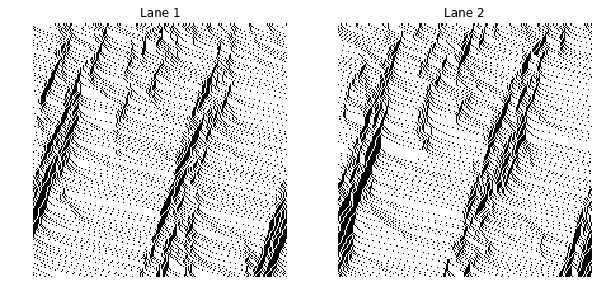

In [217]:
fig = plt.figure(figsize=(10, 5))
highway.draw(fig = fig)

In [203]:
ani = highway.video()
HTML(ani.to_html5_video())

In [0]:
def average_highway_density(sim, prune=10):
  '''
  Find the time-average highway density by averaging
  all lanes time-averaged individual density.
  '''
  density = 0
  history = np.array(sim.history)
  for lane_index in range(sim.num_lanes):
    lane_history = history[prune:, lane_index, :]
    density += average_lane_density(sim, history=lane_history)
  
  return density/sim.num_lanes
    
def average_highway_throughput(sim, prune=10):
  '''
  Find the time-average highway throughput by summing
  all lanes time-averaged throughput. This is normalized for
  lane count separately.
  '''
  throughput = 0
  history = np.array(sim.history)
  for lane_index in range(sim.num_lanes):
    lane_history = history[prune:, lane_index, :]
    throughput += average_lane_throughput(sim, history=lane_history)
  
  return throughput

def joint_congestion(sim, prune=10):
  '''
  Calculate the average rate at which a stopped car in one lane co-occurs
  with a stopped car in the adjacent lanes.
  '''
  
  history = np.array(sim.history)
  pairwise_cor_means = []
  
  # Average over each pair of lanes.
  for lane_index in range(sim.num_lanes-1):
    cor_rates = []
    
    # Average over all steps in history
    for step in range(prune, len(history)):
      first_lane_state = (history[step, lane_index, :] == 0).astype(int)
      second_lane_state = (history[step, lane_index+1, :] == 0).astype(int)
      
      # Find correlation with a window of offsets
      cor_offset_sum = 0
      offsets = range(-1, 2)
      for offset in offsets:
        stoppages = np.where(first_lane_state | second_lane_state)[0]
        co_occurence = np.correlate(
            first_lane_state[stoppages],
            np.roll(second_lane_state, offset)[stoppages])
        
        if len(stoppages) > 0:
          co_occurence_rate = co_occurence/len(stoppages)
          cor_offset_sum += co_occurence_rate
        
      cor_rates.append(1 if cor_offset_sum > 0 else 0)
    
    if len(cor_rates) > 0:
      pairwise_cor_means.append(np.mean(cor_rates))
  
  return np.mean(pairwise_cor_means)

def avg_throughput_per_lane(sim):
  return average_highway_throughput(sim)/sim.num_lanes

def stopped_car_count(sim):
  return np.sum(np.apply_along_axis(lambda x: np.sum(x==0), 0, sim.history))

def num_lane_changes(sim):
  return sim.total_lane_changes

highway_end_stats = {
    "avg_density": average_highway_density,
    "avg_total_throughput": average_highway_throughput,
    "avg_throughput_per_lane": avg_throughput_per_lane,
    "stopped_car_count": stopped_car_count,
    "stopped_correlation": joint_congestion,
    "num_lane_changes": num_lane_changes
}

In [0]:
NUM_LANES = 2
ROAD_LENGTH = 200

highway_sim_params_single = {
  "traffic_density": 0.17,
  "max_velocity": 5,
  "p_slow_down": 0.5,
  "maintain_braking_distance": False,
  "num_lanes": NUM_LANES,
  "lane_length": ROAD_LENGTH,
  "other_lane_back_gap_swap_threshold": 5,
  "p_lane_change": 1
}

highway_constant_params_single = {
  "dim": (NUM_LANES, ROAD_LENGTH),
  "neighborhood_radii": (5, 0),
  "sim_states": states,
  "metrics": {},
  "start_stats": {},
  "end_stats": highway_end_stats
}

highway = Highway(sim_params=highway_sim_params_single, **highway_constant_params_single)
highway.run_until_stable(max_steps=200, early_stop=False)

## 2.4 Comparative Analysis

Below, the `CAExperiment` class is used to run the two lane road across the same range of parameters as the single lane simulation above. This allows for comparative analysis of how flow responds to density changes for one vs two lanes.

### Average flow per lane

The plot below shows the same interval plot as above for both one and two lanes. The two lane metrics are averaged across lanes, such that the plot shows flow per lane. The results seem to agree with the observations made above when exploring the visualization. Near the critical densities, the two lane road has a noticeably higher mean flow per lane. While the difference is not quite statistically significant, at the 95% level, it is very close to it (it is significant at 87% for the little that that is worth post-fact). It is also worth noting the maximum observed flow is higher as this may be of some interest depending on road design priorities.

The increase in flow per lane narrows and eventually dissappears as the density increases. By a density of 0.4, there is no different in mean flow. This supports the hypothesis that traffic tends to co-occur between lanes such that the second lane doesn't meaningfully improve throughput in all but a narrow range of cases around where traffic is relative unlikely/'light' (as it would be in the critical region).

It is worth noting that the variation in flow, indicated by the width of the interval, is smaller for the two lane highway than the one lane road. This indicates that the two lanes do maintain a small stabilizing effect throughout, removing some of the worst case flow scenarios. This mitigation has no effect on the average flow but better worst-cases may be an important design consideration.

### Total flow

The second plot below shows total flow metrics for the single lane and highway. It is interesting to note that the maximum observed mean flow of the two lane road is 0.7, slightly more than double the single lane road at 0.33.

We would expect that an additional lane would yield a 100% increase in throughput. Any additional percent above this is an efficiency from having multiple lanes. This means that at maximum flow, two lanes support ~114% more throughput than a single lane. IE, there is a 14% gain (7% per lane) in flow. This is a more tangible way to express the benefit of multiple lanes near the critical density analyzed in the per lane metrics above.

### The Contribution of Lane Changes to Efficiency

The natural question which arises from the analysis above is how exactly the efficiency gains relate to the number of lane changes. Figure 4A below shows the number of lane changes relative to the density for the two lane road. The peak of the lane change distribution is well after the critical density at which throughput is maximized.

This has an interesting implication. It appears that relatively few lange changes are required to create the resillience described above. IE, the largest gain in per lane efficiency occurs near critical densities where the number of lange changes is relatively modest. This agrees with the first hypothesis from the visual analysis above - lane changes provide resillience in a narrow, relatively low-density window of the parameter space.

Thus, it appears that the majority of lane changes at the higher densities only have a minor effect on total throughput per lane. In so far as these lane changes waste driver effort and risk congestion by forcing other drivers to slow down, they are likely a hinderance to overall flow.

In order to lend credence to this anaylsis, we explore evidence for the second visual hypothesis: that traffic normally co-occurs across lanes. In the benchmark, we count the proportion of stopped cars which co-occur with another stopped car in the other lane (where co-occur means another car is next to or one space in front/behind the stopped car). The results of this analysis are shown in Figure 4B. The phase change near the critical density is striking in this diagram. After 0.1, the proportion of stopped car which co-occur across both lanes reaches 1 almost immediately. After this change, lane changes may be occuring but will not actually avoid queueing given a queue is present in both lanes in almost all instances.





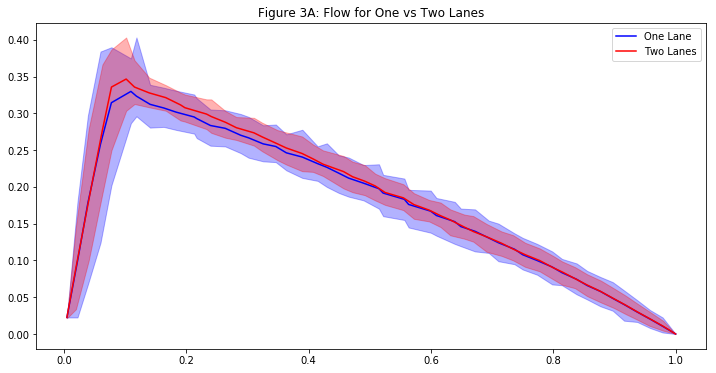

In [20]:
plot_flow_intervals("Figure 3A: Flow for One vs Two Lanes",
                    [(lane_exp.results, "b", "One Lane"),
                     (highway_exp.results, "r", "Two Lanes")])

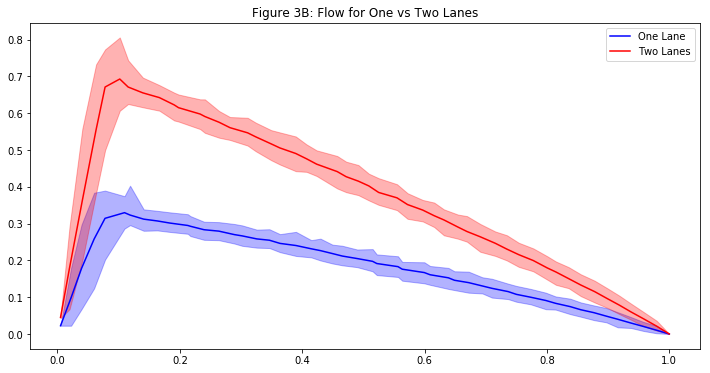

One Lane max observed flow 0.33
Two Lanes max observed flow 0.693
Percent gained from efficiency [ 10.17326733]
Percent gained from efficiency per lane [ 5.08663366]


In [21]:
plot_flow_intervals("Figure 3B: Flow for One vs Two Lanes",
                    [(lane_exp.results, "b", "One Lane"),
                     (highway_exp.results, "r", "Two Lanes")],
                   fields=["avg_throughput_per_lane", "avg_total_throughput"],
                   max_deltas=True,
                   efficiency_gains=True)

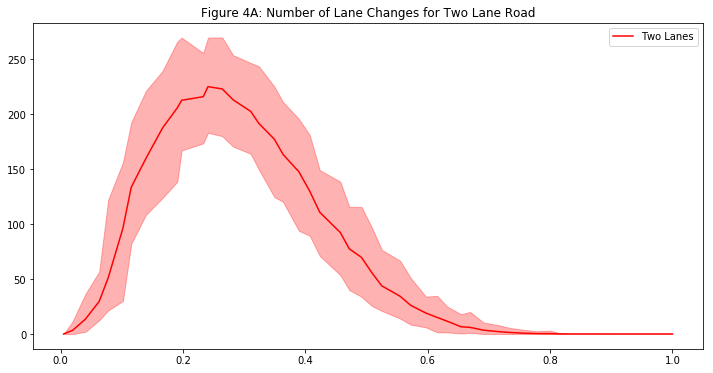

In [22]:
plot_flow_intervals("Figure 4A: Number of Lane Changes for Two Lane Road",
                    [(highway_exp.results, "r", "Two Lanes")],
                   fields=["num_lane_changes"])

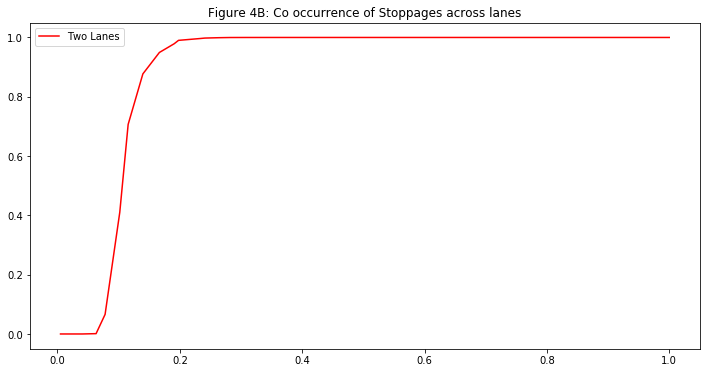

In [23]:
plot_flow_intervals("Figure 4B: Co occurrence of Stoppages across lanes",
                    [(highway_exp.results, "r", "Two Lanes")],
                   fields=["stopped_correlation"], plot_interval=False)

In [19]:
ROAD_LENGTH = 200
NUM_LANES = 2

run_params={
  "max_steps": 5*10**2,
  "early_stop": False
}

highway_sim_params_exp = {
  "traffic_density": np.linspace(0, 1, 50),
  "max_velocity": [5],
  "p_slow_down": [0.5],
  "maintain_braking_distance": [False],
  "num_lanes": [NUM_LANES],
  "lane_length": [ROAD_LENGTH],
  "other_lane_back_gap_swap_threshold": [5],
  "p_lane_change": [1]
}

highway_constant_params_exp = {
  "dim": (NUM_LANES, ROAD_LENGTH),
  "neighborhood_radii": (5, 0),
  "sim_states": states,
  "metrics": {},
  "start_stats": {},
  "end_stats": highway_end_stats
}

highway_exp = CAExperiment(
  num_repeats=100,
  sim_class=Highway,
  run_params=run_params,
  sim_params=highway_sim_params_exp,
  constant_sim_params=highway_constant_params_exp,
  stat_names = list(highway_constant_params_exp["end_stats"].keys()))

%time highway_exp.run(n_jobs=6)

Iteration time 0.244
Predicted single core total time 1220.0
CPU times: user 370 ms, sys: 170 ms, total: 540 ms
Wall time: 5min 41s


# 3. Extending to Multiple Lanes

The analysis above captures the increase in flow when moving from one to two lanes. It is interesting to consider the effects when moving from two to three or more lanes. The code below implements this. The `CAExperiment` class is used to run trials for the standard density range for lane count between 1 and 5.

**Lane Accessibility Assumption**

Beyond the assumptions discussed in the two lane model, this N-lane implementation assumes periodic lane access. IE, I simulate a taurus in which the outer and inner lane are are able access each other. This is a design choice which was made to simulate the abstract flow properties of a road rather than modelling the realistic dynamic of a multilane road. IE, my research emphasis is on how a wider road, where car has access to more total lanes over many steps, affects flow. To investigate this, it is better to remove the discontinuity/special cases created by 'realistic roads'. 

This means the simulation is not truly 'realistic' but should more accurately capture the dynamics of multilane roads.

**Analysis**

Following the same logic used above, we would expect that an additional lane would yield a 100% increase in throughput. Any additional percent above this is an efficiency from having multiple lanes. For three lanes, we would expect a 200% change from non-interacting lanes so any increase beyond this is an efficiency gain etc.

The results below show a promising pattern. The total percentage efficiency gain increases with the number of lanes. The relationship is non-linear, with each additional lane contributing a smaller amount to the effiency gained. On a per lane basis, two lanes see an increase in flow of 2.5% each, 3 lanes 5.75% each, 4 lanes 6.71% each, and 5 lanes 6.94% each.



In [0]:
ROAD_LENGTH = 100

run_params={
  "max_steps": 5*10**2,
  "early_stop": False
}

highway_sim_params_exp = {
  "traffic_density": np.linspace(0, 1, 25),
  "max_velocity": [5],
  "p_slow_down": [0.5],
  "maintain_braking_distance": [False],
  "num_lanes": range(1, 6),
  "lane_length": [ROAD_LENGTH],
  "other_lane_back_gap_swap_threshold": [5],
  "p_lane_change": [1]
}

highway_constant_params_exp = {
  "neighborhood_radii": (5, 0),
  "sim_states": states,
  "metrics": {},
  "start_stats": {},
  "end_stats": highway_end_stats
}

multilane_exp = CAExperiment(
  num_repeats=50,
  sim_class=Highway,
  run_params=run_params,
  sim_params=highway_sim_params_exp,
  constant_sim_params=highway_constant_params_exp,
  stat_names = list(highway_constant_params_exp["end_stats"].keys()))


clear_func = partial(clear_output, wait=True)
%time multilane_exp.run(n_jobs=6, clear_func=clear_func)

Percent done: 89.6


In [ ]:
# Extract results for different lane sizes, format for plotting.
results = [
    (multilane_exp.results[multilane_exp.results["num_lanes"] == l],
     COLORS[l-1],
     f"{l} Lanes")
    for l in range(1, 6)]

plot_flow_intervals(
    "Figure 5: Flow for N-lanes",
    results,
    fields=["avg_total_throughput"]*5,
    max_deltas=False,
    efficiency_gains=True)

# 4. Model Applicability

The simulation as implemented is an idealized, but fairly accurate, model of traffic in Buenos Aires. As mentioned above, the goal of this model is not to capture the minute details of the flow of traffic through a realistic road but rather to accurately model the dynamics of flow and its dependence on key macroproperties. In this sense, the validity of the model should be assessed not on how detailed the various behaviors are but on whether they produce the emergent phenomena which are visible in traffic in the city.

Three emergent phenomena are present in the model and in the city.

- The emergence of spontaneous queues: right outside our hotel, pedestrians often cross in front of oncoming traffic in the narrow one-lane road. This produces queueing (something I only noticed after starting this assignment).
- The usefulness of lane changes on wide, empty roads: Buenos Aires has a number of large multilane, one-way main roads in the city. Cabs frequently stop on the two outer lanes to collect and drop passengers. When the roads are empty, other cars simply change lanes and keep driving. 
- The uselessness of lane changes in traffic: at rush hour, the main roads are full of traffic. Many cars weave between lanes but this makes little difference to the overall flow of traffic.

All three of these phenomena occur in the model, based on the analysis above. So it is accurate in abstract and would likely produce valid insight into scaling behaviour of the roads in the city and the impact of different driver (abstract) behaviors.

There are a number of inaccuracies in the model which do not necessarily affect the abstract accuracy. The lane change behaviour of drivers is highly naive. In Buenos Aires, faster drivers stay in the left lane and slow drivers in the right lane. This is not modelled in my simulation. Drivers also look more than one car ahead to determine speed/acceleration, meaning their reactions are smoother and more 'intelligent' given the use of more information. It is unclear whether including these details would affect the results in any way. My hunch would be no.

# 5. Stretch Goal: Driver Behaviour

Below, I explore the impact of good and bad driver behaviour on throughput.

## 5.1 Good driver behaviour

When the parameter `maintain_braking_distance` is set to True, drives use a special good-driving strategy inspired by [the video](https://www.youtube.com/watch?v=iHzzSao6ypE) we watched in session 4.2. In this strategy, drivers accelerate/brake  (increasing/decreasing velocity) in order to stay in the middle of the drivers in front and behind. As described in the video, this maximizes the breaking distance from you to the car in the front and from you to the car behind, thus minimizing the probability that a random breaking event causes the spontaneous emergence of a queue/congestion.

This change has a dramatic effect impact on throughput, as evidenced by the graphic below. Experimental benchmarks are shown for a single lane with and without good driving. With good driving, the critical density at which congestion begins to dominate increased density is shifted from about 0.1 to ~0.2. This means almost double the number of cars can use the road before congestion effects begin reduce flow, producing a maximum throughput almost double that of the original driving strategy. The maximum mean throughput with good driving is 0.54 vs 0.33 without the good driving strategy.

The second plot shows the total number of occurrences of a stopped car (velocity=0) for each strategy across different densities. It is clear that throughout the middle of the density range, there are far more occurrences of stopped cars. This is indirect evidence that the causal explanation for why the strategy is superior holds true. With maximized breaking distance, there are fewer complete stops and thus there is less surface for congestion to form.

**Implication for self driving cars?**: interestingly, self-driving cars represent the potential to implement the limiting case of the good driving strategy analyzed above. In my implementation, each driver relies on delayed information about the driver in front and behind in order to make adjusts. When the front gap increases by one, the driver can then accelerate (one step later) to move into the new space. Self-driving cars could achieve similar outcomes without delay because of the ability to communicate plans instantly over distance. All cars could thus 'stay in the middle' of their neighbours while accelerating simultaneously (which is not possible with human drivers). This would allow cars to reach their max speed faster.

In essence, self-driving cars would do well to maintain the exact strategy implemented but could implement it much more effectively.

In [170]:
ROAD_LENGTH = 100

run_params={
  "max_steps": 5*10**2,
  "early_stop": False
}

highway_sim_params_exp = {
  "traffic_density": np.linspace(0, 1, 30),
  "max_velocity": [5],
  "p_slow_down": [0.5],
  "maintain_braking_distance": [False, True],
  "num_lanes": [1],
  "lane_length": [ROAD_LENGTH],
  "other_lane_back_gap_swap_threshold": [5],
  "p_lane_change": [1]
}

highway_constant_params_exp = {
  "neighborhood_radii": (5, 0),
  "sim_states": states,
  "metrics": {},
  "start_stats": {},
  "end_stats": highway_end_stats
}

good_driver_exp = CAExperiment(
  num_repeats=50,
  sim_class=Highway,
  run_params=run_params,
  sim_params=highway_sim_params_exp,
  constant_sim_params=highway_constant_params_exp,
  stat_names = list(highway_constant_params_exp["end_stats"].keys()))

%time good_driver_exp.run()

Iteration time 0.035
Predicted total time 105.0
CPU times: user 2min 58s, sys: 100 ms, total: 2min 59s
Wall time: 2min 59s


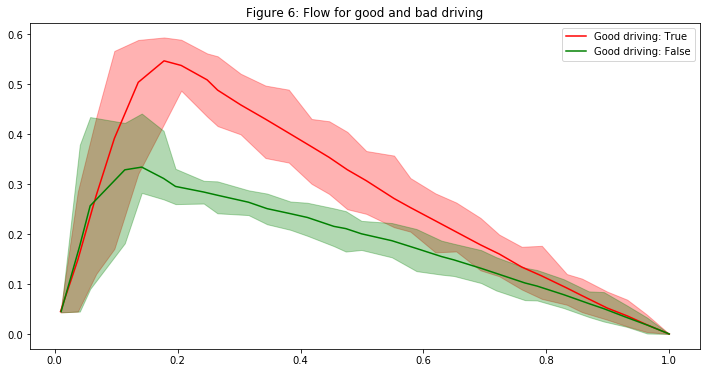

Good driving: True max observed flow 0.547
Good driving: False max observed flow 0.334


In [171]:
# Extract results for different simulations, format for plotting.
results = [
    (good_driver_exp.results[good_driver_exp.results["maintain_braking_distance"] == good_driver],
     COLORS[i],
     f"Good driving: {good_driver}")
    for i, good_driver in enumerate([True, False])]

plot_flow_intervals("Figure 6: Flow for good and bad driving", results, max_deltas=True)

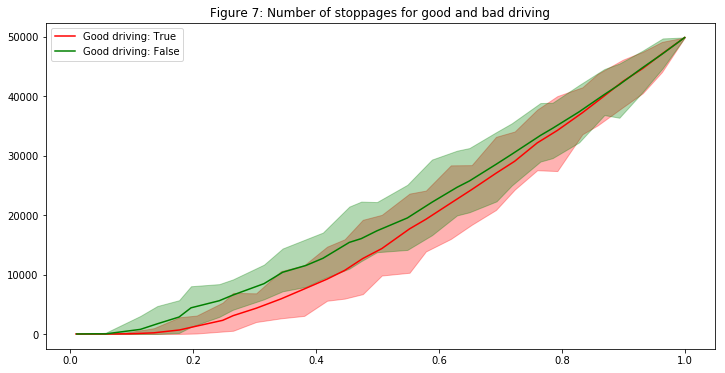

In [172]:
plot_flow_intervals("Figure 7: Number of stoppages for good and bad driving",
                    results, max_deltas=False, fields=["stopped_car_count"]*2)

## 5.2 Bad Driver Behavior

Below, I explore bad driver behaviour - in this case, the probability to randomly slow down in a time step forcing other cars to slow down to avoid a collision.

I ran benchmarks for probabilities of slowing down between 0 and 0.5 (any higher than this would encroach on the realm of highly unrealistic). The outcome is clear from the figure below. Each respective increase in probability, reduces the density at which congestion effects dominate and thus lowers the maximum throughput of the road. The magnitude of the decrease is striking. When the probability of slowdown is 0.5, the throughput is less than half the throughput when the probability is 0. The impact of increased probability shows a non-linear pattern - the largest impact is from the first change, from 0 to 0.125 probability, which decreases throughput by 25%.

Based on this, smooth/non-jerky (pun intended) driving appears to be of paramount importance. The question is how to achieve this. I argue that jerkiness is a function of road quality and speed. If the road has unexpected features, like sharp corners or potholes, drivers will slow down more. If we hold road quality constant, then speed matters because of reaction times and surprise. A driver driving fast is less likely to see an obstacle in the window of time in which calm processing is possible. Thus, they are more likely to be surprised and to engage knee-jerk braking reactions. This implies throughput could be higher if drivers drove slower and steadier. 

However, there is a problem with this. Driving slow would also decrease throughput. So, as a final experiment. I compare lower speed, lower jerk driving to higher speed and higher jerk driving. The results are discussed below.


In [184]:
ROAD_LENGTH = 100

run_params={
  "max_steps": 5*10**2,
  "early_stop": False
}

P_SLOW_DOWN_RANGE = np.linspace(0, 0.5, 5)
highway_sim_params_exp = {
  "traffic_density": np.linspace(0, 1, 30),
  "max_velocity": [5],
  "p_slow_down": P_SLOW_DOWN_RANGE,
  "maintain_braking_distance": [False],
  "num_lanes": [1],
  "lane_length": [ROAD_LENGTH],
  "other_lane_back_gap_swap_threshold": [5],
  "p_lane_change": [1]
}

highway_constant_params_exp = {
  "neighborhood_radii": (5, 0),
  "sim_states": states,
  "metrics": {},
  "start_stats": {},
  "end_stats": highway_end_stats
}

bad_driver_exp = CAExperiment(
  num_repeats=20,
  sim_class=Highway,
  run_params=run_params,
  sim_params=highway_sim_params_exp,
  constant_sim_params=highway_constant_params_exp,
  stat_names = list(highway_constant_params_exp["end_stats"].keys()))

%time bad_driver_exp.run()

Iteration time 0.038
Predicted total time 114.0
CPU times: user 1min 43s, sys: 50 ms, total: 1min 43s
Wall time: 1min 43s


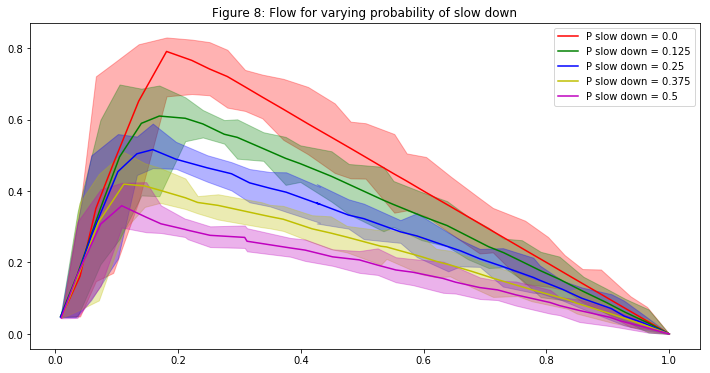

P slow down = 0.0 max observed flow 0.791
P slow down = 0.125 max observed flow 0.61
P slow down = 0.25 max observed flow 0.516
P slow down = 0.375 max observed flow 0.419
P slow down = 0.5 max observed flow 0.359


In [185]:
# Extract results for different simulations, format for plotting.
results = [
    (bad_driver_exp.results[bad_driver_exp.results["p_slow_down"] == p_slow_down],
     COLORS[i],
     f"P slow down = {p_slow_down}")
    for i, p_slow_down in enumerate(P_SLOW_DOWN_RANGE)]

plot_flow_intervals("Figure 8: Flow for varying probability of slow down",
                    results, max_deltas=True)

### Slow and Steady vs Fast and Jerky

Below, I compare the throughput of a simulation with a max velocity of 2 and a probability of slowdown of 0.05 and a simulation with max velocity 5 and a probability of slow down of 0.5.

The result of the comparison is clear but quite counterintuitive. The lower max velocity with smoother driving produces a much higher maximum throughput with a different transition behavior. Unlike the original experiment, there does not appear to be a sharp kink characterised by uncertainty. Rather, there is a gradual decrease in the returns to increased density up to a peak at density around 0.4 where the uncertainty/variance is actually relatively small. I suspect the lower uncertainty is a consequence of the smaller range of possible velocities rather than a true change in the functioning of the system around this point.

The throughput at the peak of the smooth, slow simulation is around 0.5 cars per step. This is 66% higher than the maximum throughput with a higher max velocity and higher probability of slow down.

This is decisive evidence that smooth driving is important. It is also indirect evidence of a benefit accrued from speed limits. If imposing a low ceiling on max speed gives drivers time to be less reactive/jerky, then it will have a positive impact on throughput despite the lower speed.

In [189]:
ROAD_LENGTH = 100

run_params={
  "max_steps": 5*10**2,
  "early_stop": False
}

P_SLOW_DOWN_RANGE = np.linspace(0, 0.35, 5)
highway_sim_params_exp = {
  "traffic_density": np.linspace(0, 1, 30),
  "max_velocity": [2, 5],
  "p_slow_down": [0.05, 0.5],
  "maintain_braking_distance": [False],
  "num_lanes": [1],
  "lane_length": [ROAD_LENGTH],
  "other_lane_back_gap_swap_threshold": [5],
  "p_lane_change": [1]
}

highway_constant_params_exp = {
  "neighborhood_radii": (5, 0),
  "sim_states": states,
  "metrics": {},
  "start_stats": {},
  "end_stats": highway_end_stats
}

tradeoff_exp = CAExperiment(
  num_repeats=20,
  sim_class=Highway,
  run_params=run_params,
  sim_params=highway_sim_params_exp,
  constant_sim_params=highway_constant_params_exp,
  stat_names = list(highway_constant_params_exp["end_stats"].keys()))

%time tradeoff_exp.run()

Iteration time 0.036
Predicted total time 86.4
CPU times: user 1min 21s, sys: 120 ms, total: 1min 22s
Wall time: 1min 22s


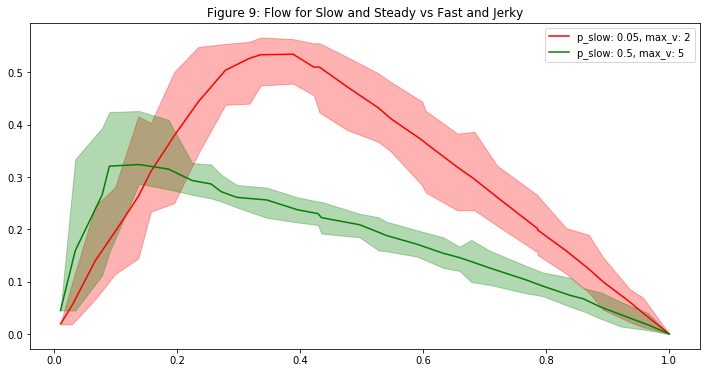

p_slow: 0.05, max_v: 2 max observed flow 0.534
p_slow: 0.5, max_v: 5 max observed flow 0.324


In [192]:
# Extract results for different simulations sizes, format for plotting.
results = [
    (tradeoff_exp.results[np.logical_and(
        tradeoff_exp.results["p_slow_down"] == p_slow_down,
        tradeoff_exp.results["max_velocity"] == max_v)],
     COLORS[i],
     f"p_slow: {p_slow_down}, max_v: {max_v}")
    for i, (p_slow_down, max_v) in enumerate([(0.05, 2), (0.5, 5)])]

plot_flow_intervals("Figure 9: Flow for Slow and Steady vs Fast and Jerky", results, max_deltas=True)

## Plotting Code

In [0]:
COLORS = ["r", "g", "b", "y", "m", "c", "k"]

def plot_flow_intervals(title, results,
                        plot_interval=True,
                        fields=None,
                        max_deltas=False,
                        efficiency_gains=False):
  """
  Plot given fields over the range of densities given a list of experiment
  results.
  """
  plt.figure(figsize=(12, 6))
  plt.title(title)
  
  labels = []
  means = []
  # Construct interval for each experiment.
  for i, (res, color, label) in enumerate(results):
    if fields is not None:
      field = fields[i]
    else:
      field = "avg_throughput_per_lane"
      
    bin_xs = []
    bin_means = []
    bin_uppers = []
    bin_lowers = []
    for _, m in res.groupby("traffic_density"):
        bin_xs.append(m.avg_density.mean())
        data = m[field]
        mean = data.mean()
        bin_means.append(mean)

        bin_uppers.append(data.quantile(0.975))
        bin_lowers.append(data.quantile(0.025))
    
    labels.append(label)
    means.append(np.array(bin_means))
    plt.plot(bin_xs, bin_means, color=color, label=label)
    if plot_interval:
      plt.fill_between(bin_xs, bin_lowers, bin_uppers, alpha=0.3, color=color)
  
  plt.legend()
  plt.show()
  
  
  if max_deltas:
    for label, mean in zip(labels, means):
      print(label, "max observed flow", np.round(np.max(mean), 3))
      
  if efficiency_gains:
    means = np.vstack(means)
    
    max_means = np.max(means, axis=1)
    
    # Find the percent gain relative to one lane
    percent_gain_vs_one = 100*(max_means[1:] - max_means[0])/max_means[0]
    
    # Find expected gain based on simple parallelism
    expected_gain = np.arange(1, len(means))*100
    
    # Find additional gain, which is 'efficiency'.
    additional_gain = percent_gain_vs_one - expected_gain
    
    print("Percent gained from efficiency", additional_gain)
    print("Percent gained from efficiency per lane",
          additional_gain/np.arange(2, len(means)+1))